In [64]:
import torch
from utils import *
from collections import defaultdict
import matplotlib.pyplot as plt
import time

from render import *
from model import *

import metrics

from dataset import dataset_dict


torch.backends.cudnn.benchmark = True

img_wh = (256, 256)

# dataset = dataset_dict['blender'] \
#           ('/home/timothy/Desktop/2023Spring/my_nerf/nerf_synthetic/lego', 'val', 
#            img_wh=(800,800))

dataset = dataset_dict['klevr'] \
          ('/home/timothy/Desktop/2023Spring/GeoNeRF/data/data/nesf_data/klevr/1', split='val',
           img_wh=img_wh)

In [65]:
embedding_xyz = Positional_Embedding(10)
embedding_dir = Positional_Embedding(4)

nerf_coarse = NeRF()
nerf_fine = NeRF()
# ckpt_path = "/home/timothy/Desktop/2023Spring/my_nerf/ckpts/exp_nesf_1/epoch=10-step=147840.ckpt"
# ckpt_path = '/home/timothy/Desktop/2023Spring/my_nerf/ckpts/exp_nesf/epoch=15-step=295936.ckpt'
# ckpt_path = '/home/timothy/Desktop/2023Spring/my_nerf/ckpts/nesf1_white_back_false/epoch=14-step=201600.ckpt'
ckpt_path = "/home/timothy/Desktop/2023Spring/my_nerf/ckpts/nesf1_calculate_near_far_revise/epoch=9-step=134400.ckpt"
# ckpt_path = "/home/timothy/Desktop/2023Spring/my_nerf/ckpts/nesf1/epoch=15-step=215040.ckpt"
# lego
# ckpt_path = '/home/timothy/Desktop/2023Spring/my_nerf/ckpts/exp_white_back_false/epoch=15-step=250000.ckpt'

load_ckpt(nerf_coarse, ckpt_path, model_name='nerf_coarse')
load_ckpt(nerf_fine, ckpt_path, model_name='nerf_fine')

nerf_coarse.cuda().eval()
nerf_fine.cuda().eval()

NeRF(
  (xyz_layers): ModuleList(
    (0): Linear(in_features=63, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): Linear(in_features=319, out_features=256, bias=True)
    (5): Linear(in_features=256, out_features=256, bias=True)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Linear(in_features=256, out_features=256, bias=True)
  )
  (xyz_encoding_final): Linear(in_features=256, out_features=256, bias=True)
  (dir_layer): Sequential(
    (0): Linear(in_features=283, out_features=128, bias=True)
    (1): ReLU(inplace=True)
  )
  (sigma): Linear(in_features=256, out_features=1, bias=True)
  (rgb_output): Sequential(
    (0): Linear(in_features=128, out_features=3, bias=True)
    (1): Sigmoid()
  )
)

In [66]:
models = [nerf_coarse, nerf_fine]
embeddings = [embedding_xyz, embedding_dir]

N_samples = 128
N_importance = 128
use_disp = False
chunk = 1024*32*4

@torch.no_grad()
def batched_inference(models, embeddings,
                      rays, N_samples, N_importance, use_disp,
                      chunk,
                      white_back):
    """Do batched inference on rays using chunk."""
    B = rays.shape[0]
    chunk = 1024*32
    results = defaultdict(list)
    for i in range(0, B, chunk):
        rendered_ray_chunks = \
            render_rays(models,
                        embeddings,
                        rays[i:i+chunk],
                        N_samples,
                        use_disp,
                        0,
                        0,
                        N_importance,
                        chunk,
                        dataset.white_back,
                        test_time=True)

        for k, v in rendered_ray_chunks.items():
            results[k] += [v]

    for k, v in results.items():
        results[k] = torch.cat(v, 0)
    return results

In [67]:
sample = dataset[10]
rays = sample['rays'].cuda()
print(rays.shape)
t = time.time()
results = batched_inference(models, embeddings, rays,
                                    N_samples, N_importance, use_disp,
                                    chunk,
                                    dataset.white_back)
torch.cuda.synchronize()
print(time.time()-t)

torch.Size([65536, 8])
3.474669933319092


In [68]:
import torchvision.transforms as T
import numpy as np
import cv2
from PIL import Image

def visualize_depth(depth, cmap=cv2.COLORMAP_JET):
    """
    depth: (H, W)
    """
    x = depth.cpu().numpy()
    x = np.nan_to_num(x) # change nan to 0
    mi = np.min(x) # get minimum depth
    ma = np.max(x)
    x = (x-mi)/(ma-mi+1e-8) # normalize to 0~1
    x = (255*x).astype(np.uint8)
    x_ = Image.fromarray(cv2.applyColorMap(x, cmap))
    x_ = T.ToTensor()(x_) # (3, H, W)
    return x_

PSNR 21.702640533447266


/tmp/ipykernel_4037363/1836612886.py:10: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


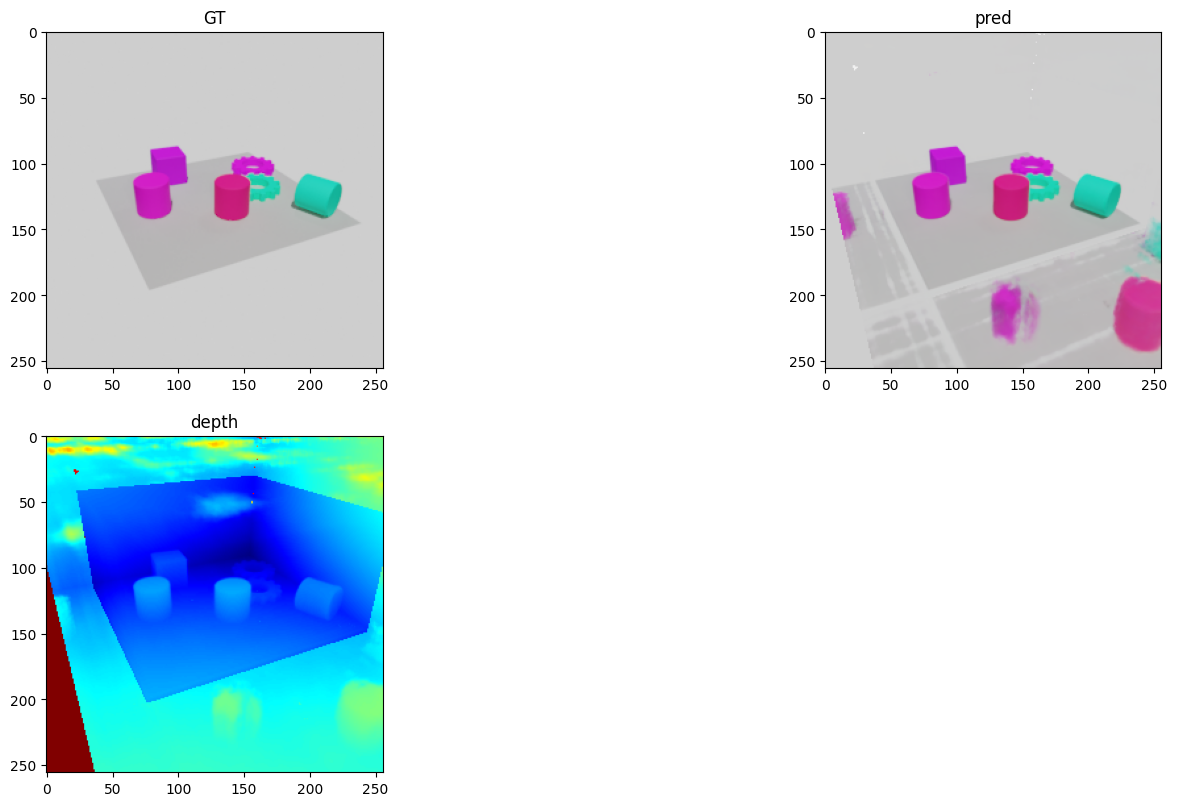

In [69]:
img_gt = sample['rgbs'].view(img_wh[1], img_wh[0], 3)
img_pred = results['rgb_fine'].view(img_wh[1], img_wh[0], 3).cpu().numpy()
alpha_pred = results['opacity_fine'].view(img_wh[1], img_wh[0]).cpu().numpy()
depth_pred = results['depth_fine'].view(img_wh[1], img_wh[0])

print('PSNR', metrics.psnr(img_gt, img_pred).item())

plt.subplots(figsize=(15, 8))
plt.tight_layout()
plt.subplot(221)
plt.title('GT')
plt.imshow(img_gt)
plt.subplot(222)
plt.title('pred')
plt.imshow(img_pred)
plt.subplot(223)
plt.title('depth')
plt.imshow(visualize_depth(depth_pred).permute(1,2,0))
plt.show()

In [70]:
# from PIL import Image

# segmentation_path = "/home/timothy/Desktop/2023Spring/GeoNeRF/data/data/nesf_data/klevr/2/segmentation_00299.png"
# Image.open